# The Mission
The real estate company "ImmoEliza" ask you to create a machine learning model to predict prices on Belgium's sales.

## Step 1 : Data Cleaning**
You have collected your data, you have cleaned and analyze it a first time!
So it's time to do some machine learning with it!

But first, we have to prepare the data for machine learning.

No duplicates
No NANs
No text data
No features that have too strong correlation between them

In [1]:
# import module /library here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import os
from sklearn.linear_model  import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split


In [2]:

# To display plots in notebook
%matplotlib inline
# To display rows and columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [3]:
# load data from csv
immoweb_logicimmo = pd.read_csv('https://raw.githubusercontent.com/JulienAlardot/challenge-collecting-data/main/Data/database.csv', sep=',')
immoweb_logicimmo.shape

(73510, 24)

##### Change column names to lower case to make column names look same manner
##### Drop columns not needed for Prediction or to find duplicate the  Unnamed: 0,Url and Source columns
##### Replace space in column with "_" to make it access with data frame easily

In [4]:
immoweb_logicimmo.rename(str.lower,axis=1,inplace=True)
immoweb_logicimmo.drop(columns=['unnamed: 0','url','source'], errors='ignore',inplace=True)
immoweb_logicimmo.columns = immoweb_logicimmo.columns.str.replace(' ','_')
immoweb_logicimmo.columns

Index(['locality', 'type_of_property', 'subtype_of_property', 'price',
       'type_of_sale', 'number_of_rooms', 'area', 'fully_equipped_kitchen',
       'furnished', 'open_fire', 'terrace', 'terrace_area', 'garden',
       'garden_area', 'surface_of_the_land',
       'surface_area_of_the_plot_of_land', 'number_of_facades',
       'swimming_pool', 'state_of_the_building', 'province', 'region'],
      dtype='object')

##### Find Duplicates and drop the duplicates

In [5]:
immoweb_logicimmo.duplicated().any(), immoweb_logicimmo.drop_duplicates(inplace=True),immoweb_logicimmo.shape
#73510-73441 = 69 rows are duplicates

(True, None, (73441, 21))

##### Find Missing Values and Pertentage of them

In [6]:
count_of_missing_values_per_column = immoweb_logicimmo.isna().sum()
percent_of_missing_values_in_dataset = (count_of_missing_values_per_column/immoweb_logicimmo.shape[0])*100
percent_of_missing_values_in_dataset

locality                             0.000000
type_of_property                     0.517422
subtype_of_property                 79.963508
price                                1.367084
type_of_sale                         0.000000
number_of_rooms                      1.230920
area                                15.325227
fully_equipped_kitchen               0.000000
furnished                           27.259977
open_fire                            0.000000
terrace                              0.000000
terrace_area                        68.348743
garden                               0.000000
garden_area                         85.042415
surface_of_the_land                 52.529241
surface_area_of_the_plot_of_land    52.529241
number_of_facades                   51.188028
swimming_pool                        0.000000
state_of_the_building               44.910881
province                             0.000000
region                               0.000000
dtype: float64

#####  Analyze to drop rows having missing values and columns having missing Values and find importance
    a. Drop rows where subtype of property and type of property is na
    b. Drop surface_area_of_the_plot_of_land as it is similar as surface_of_the_land
    c. Drop rows of public sales and then drop type_of_sale column
    d. Drop rows having price as nan/null
    e. Number of rooms na and area na to be removed and then
     other rows with a and 0 neds to be filled with average number of rooms
    f.Replace Area with Average Area
    g.Funrished column to be filled with bfill and then remaining with average value of the column
    h Surface of the land is calculated depending on area+10% and type of property apartment have 0
    i.Terrace area with average value for the rows which are having terrace and
    j.Do the same as like terrace area to garden area as well
    k.number of facades
    l.state_of_building create new category to fill na
    m. Divide type_of_property ,state_of_the_building,province and region in to new columns

In [7]:
# a. 308 rows having type_of_property na and sub type of property na ,so dropping them
immoweb_logicimmo.dropna(subset=['type_of_property','subtype_of_property'] ,how='all',inplace=True)
immoweb_logicimmo.type_of_property.fillna(method="bfill",inplace=True)
immoweb_logicimmo[immoweb_logicimmo.type_of_property.isna()][['type_of_property','subtype_of_property']],immoweb_logicimmo.shape

(Empty DataFrame
 Columns: [type_of_property, subtype_of_property]
 Index: [],
 (73133, 21))

In [8]:
# b.Drop surface_area_of_the_plot_of_land
immoweb_logicimmo.drop(columns=['surface_area_of_the_plot_of_land'],inplace=True,errors='ignore')
immoweb_logicimmo.shape

(73133, 20)

In [9]:
# c. Drop public sale rows as it might have impact on prediction and then drop type of sale column as it is having single value
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.type_of_sale =='public sale'].index,inplace=True, errors='ignore')
immoweb_logicimmo.drop(columns=['type_of_sale'],inplace=True,errors='ignore')
immoweb_logicimmo.shape

(72089, 19)

In [10]:
#d.Drop rows having no price also few rows having area and price same drop them as well
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.price.isna()].index,inplace=True)
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.price ==immoweb_logicimmo.area].index,inplace=True)
immoweb_logicimmo.shape

(71094, 19)

In [11]:
#e. Drop rows having Area and Number of rooms as na also number of rooms zero and no area, fill number of rooms na with
# average of number of rooms to make consistent distribution across all records
immoweb_logicimmo.dropna(subset=['area','number_of_rooms'] ,how='all',inplace=True)
immoweb_logicimmo.drop(immoweb_logicimmo[(immoweb_logicimmo.number_of_rooms ==0.0)&(immoweb_logicimmo.area.isna())].index,inplace=True)
average_number_of_rooms= round(immoweb_logicimmo.number_of_rooms.mean())
immoweb_logicimmo.number_of_rooms.fillna(average_number_of_rooms,inplace=True)
immoweb_logicimmo.number_of_rooms = np.where(immoweb_logicimmo.number_of_rooms ==0.0,average_number_of_rooms,immoweb_logicimmo.number_of_rooms )

In [12]:
#f.Area and surface_of_the_land are na then drop them
immoweb_logicimmo.dropna(subset=['area','surface_of_the_land'] ,how='all',inplace=True)
average_area= round(immoweb_logicimmo.area.mean())
immoweb_logicimmo.area.fillna(average_area,inplace=True)

In [13]:
#g.furnished with bfill algorithm as there is no way we can find and we can fill by province the value
immoweb_logicimmo.furnished.fillna(method='bfill',inplace=True)
immoweb_logicimmo.furnished = np.where(immoweb_logicimmo.furnished.isna()&immoweb_logicimmo.province =='Brussels',1,immoweb_logicimmo.furnished)
immoweb_logicimmo.furnished.fillna(0,inplace=True)
immoweb_logicimmo.isna().sum()

locality                      0
type_of_property              0
subtype_of_property       53527
price                         0
number_of_rooms               0
area                          0
fully_equipped_kitchen        0
furnished                     0
open_fire                     0
terrace                       0
terrace_area              44353
garden                        0
garden_area               56259
surface_of_the_land       33790
number_of_facades         32675
swimming_pool                 0
state_of_the_building     28815
province                      0
region                        0
dtype: int64

In [14]:
#h Surface of the land is calculated depending on area+10% and type of property apartment have 0
immoweb_logicimmo[(immoweb_logicimmo.surface_of_the_land.isna()) & (immoweb_logicimmo.type_of_property=='house')][['type_of_property','surface_of_the_land']]
immoweb_logicimmo.surface_of_the_land = np.where(((immoweb_logicimmo.surface_of_the_land.isna()) & (immoweb_logicimmo.type_of_property =='house')),(immoweb_logicimmo.area*1.10),immoweb_logicimmo.surface_of_the_land)
immoweb_logicimmo.surface_of_the_land = np.where(((immoweb_logicimmo.surface_of_the_land.isna()) & (immoweb_logicimmo.type_of_property =='apartment')),0.0,immoweb_logicimmo.surface_of_the_land)

In [15]:
#h. Terrace is  there and terrace area is na and filled up with 10% area
average_terrace_area= immoweb_logicimmo.terrace_area.mean()/10
immoweb_logicimmo.terrace_area= np.where(immoweb_logicimmo.terrace ==0.0,0.0,immoweb_logicimmo.terrace_area)
immoweb_logicimmo.terrace_area= np.where(((immoweb_logicimmo.terrace_area.isna())&(immoweb_logicimmo.terrace ==1.0)),(immoweb_logicimmo.area*0.10),immoweb_logicimmo.terrace_area)

In [16]:
#i. garden area is depeding on surface area of land
immoweb_logicimmo.garden_area= np.where(immoweb_logicimmo.garden ==0.0,0.0,immoweb_logicimmo.garden_area)
immoweb_logicimmo.garden_area= np.where(((immoweb_logicimmo.garden_area.isna())&(immoweb_logicimmo.garden ==1.0)),(immoweb_logicimmo.surface_of_the_land*0.10),immoweb_logicimmo.garden_area)

In [17]:
#j number of facades are difficult to calculate so took average but they make no value to prediction?
average_number_of_facades = immoweb_logicimmo.number_of_facades.median()
immoweb_logicimmo[['type_of_property','number_of_facades']]
immoweb_logicimmo.number_of_facades = np.where((immoweb_logicimmo.number_of_facades.isna()) & (immoweb_logicimmo.type_of_property=='house'),average_number_of_facades,0)

In [18]:
#k.good,new,to reovate,oldandgood
immoweb_logicimmo.state_of_the_building.unique()
immoweb_logicimmo.state_of_the_building.fillna('old',inplace=True)
immoweb_logicimmo.isna().sum()

locality                      0
type_of_property              0
subtype_of_property       53527
price                         0
number_of_rooms               0
area                          0
fully_equipped_kitchen        0
furnished                     0
open_fire                     0
terrace                       0
terrace_area                  0
garden                        0
garden_area                   0
surface_of_the_land           0
number_of_facades             0
swimming_pool                 0
state_of_the_building         0
province                      0
region                        0
dtype: int64

In [19]:
#Imputation from sklearn for filling up nan values in  Dataframe columns can be used.....need to be tried.
#OneHotEncoder from sklearn for categorical columns  to divide them
# For type_of_property
for property_type in (immoweb_logicimmo.type_of_property.unique()):
    immoweb_logicimmo[property_type] = np.where(immoweb_logicimmo.type_of_property == property_type, 1, 0)

In [20]:
# Creating numeric column for type_of_property by having the value but not good as they are given priority  using price
mean_price_by_type = immoweb_logicimmo[['type_of_property', 'price']].groupby('type_of_property').mean('price')
mapping_score_ = round(mean_price_by_type['price'].sort_values(ascending=False) / 1000000, 2)
mapping_score_type = dict(mapping_score_)
immoweb_logicimmo['type_of_property_num'] = immoweb_logicimmo['type_of_property'].apply(lambda x: mapping_score_type.get(x, 0))

In [21]:
# For state_of_the_building create new columns
for buildingstate in (immoweb_logicimmo.state_of_the_building.unique()):
    immoweb_logicimmo[buildingstate] = np.where(immoweb_logicimmo.state_of_the_building == buildingstate, 1, 0)

In [22]:
# For province creating new columns
for province in (immoweb_logicimmo.province.unique()):
    immoweb_logicimmo[province] = np.where(immoweb_logicimmo.province == province, 1, 0)

In [23]:
# create new numeric column for region also depends on price given priority and score
mean_price_by_province = immoweb_logicimmo[['province', 'price']].groupby('province').mean('price')
mapping_score = round(mean_price_by_province['price'].sort_values(ascending=False) / 1000000, 2)
mapping_score_province = dict(mapping_score)
immoweb_logicimmo['province_num'] = immoweb_logicimmo['province'].apply(lambda x: mapping_score_province.get(x, 0))

In [24]:
# For region create categorical columns
for region in (immoweb_logicimmo.region.unique()):
    immoweb_logicimmo[region] = np.where(immoweb_logicimmo.region == region, 1, 0)

In [25]:
# create new numerical column for region depends on price
mean_price_by_region = immoweb_logicimmo[['region', 'price']].groupby('region').mean('price')
mapping_score_r = round(mean_price_by_region['price'].sort_values(ascending=False) / 1000000, 2)
mapping_score_region = dict(mapping_score_r)
immoweb_logicimmo['region_num'] = immoweb_logicimmo['region'].apply(lambda x: mapping_score_region.get(x, 0))

In [26]:
# creating new  categorical columns for locality
# postal_codes =pd.read_csv('./postal_codes.csv',sep=";")
# codes_value = postal_codes.iloc[:,0:2].to_dict(orient='split').get('data')
# pcode_lname ={}
# for item in codes_value:
#     pcode_lname[item[0]]= item[1]
# #pcode_lname

In [27]:
# For Locality categorize columns
loc_columns =[]
for locality in (immoweb_logicimmo.locality.unique()):
    column_name= 'loc_'+str(locality)
    loc_columns.append(column_name)
    immoweb_logicimmo[column_name] = np.where(immoweb_logicimmo.locality == locality, 1, 0)
print(len(loc_columns))

988


In [28]:
#fill 
immoweb_logicimmo.subtype_of_property.fillna("house-apartment-sub",inplace=True)

In [29]:
# For Sub type of property create categorical columns
for subtype_of_property in (immoweb_logicimmo.subtype_of_property.unique()):
    immoweb_logicimmo[subtype_of_property] = np.where(immoweb_logicimmo.subtype_of_property == subtype_of_property, 1, 0)

In [30]:
# replace space in columns newly created with '_'
immoweb_logicimmo.columns = immoweb_logicimmo.columns.str.replace(' ','_')

[]

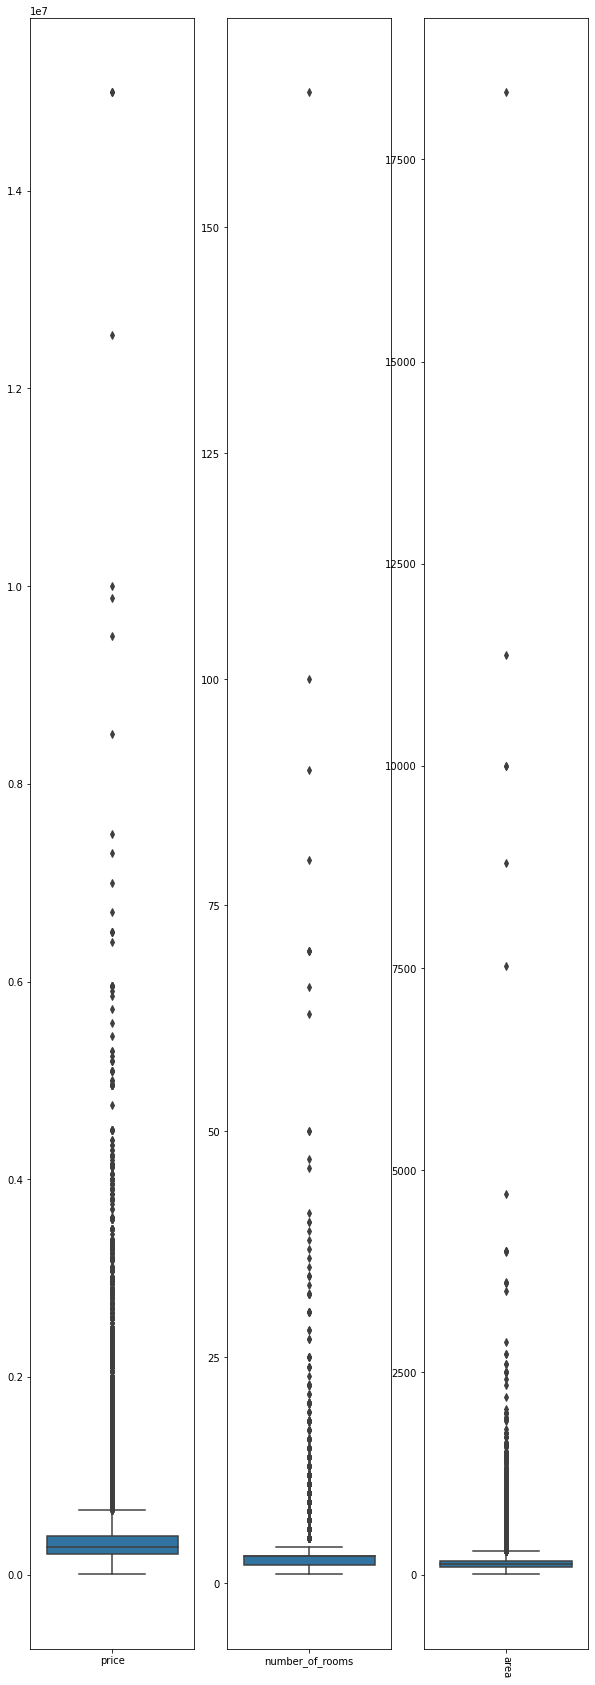

In [31]:
# Trying to find the rows having effect on prediction
plt.figure(figsize = (10 , 30))
plt.subplot(131)
sns.boxplot(data=immoweb_logicimmo[['price']])
plt.subplot(132)
sns.boxplot(data=immoweb_logicimmo[['number_of_rooms']])
plt.subplot(133)
sns.boxplot(data=immoweb_logicimmo[['area']])
plt.xticks(rotation=-90);
plt.plot()

In [32]:
# depending on above result we change the rows to be taken
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.price >4500000].index,inplace=True)
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.number_of_rooms>21].index,inplace=True)
immoweb_logicimmo.drop(immoweb_logicimmo[immoweb_logicimmo.area>1750].index,inplace=True)

In [33]:
# Find correlation
immoweb_logicimmo.corr().head(2)

,locality,price,number_of_rooms,area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,surface_of_the_land,number_of_facades,swimming_pool,apartment,house,type_of_property_num,old,good,new,to_renovate,Antwerp,Vlaams-Brabant,West-Vlanderen,Liège,Oost-Vlanderen,Namur,Brussels,Hainaut,Luxembourg,Brabant_Wallon,Limburg,province_num,Vlaams,Wallonie,Brussels_Capital,region_num,loc_2970,loc_3200,loc_8211,loc_2630,loc_4432,loc_9300,loc_1652,loc_4540,loc_5300,loc_1070,loc_6150,loc_4821,loc_4031,...,loc_9552,loc_6833,loc_6750,loc_3581,loc_9961,loc_6836,loc_9970,loc_6666,loc_6661,loc_5520,loc_5372,loc_3971,loc_6970,loc_8431,loc_6663,loc_6823,loc_8573,loc_9451,loc_9042,loc_8978,loc_4701,loc_3051,loc_7643,loc_2811,loc_8581,loc_3118,loc_4711,loc_2531,house-apartment-sub,penthouse,studio,duplex,loft,ground_floor,triplex,building,student,investment_property,villa,mansion,mixed,apartments_row,farmhouse,castle,floor,town,service_flat,cottage,manor,pavilion
locality,1.000000,-0.138914,-0.006681,-0.039109,-0.128616,0.016611,-0.066248,-0.126451,-0.035426,-0.008643,-0.011757,-0.009083,0.150992,-0.026932,-0.108835,0.108835,0.108835,0.108433,-0.075818,-0.060573,-0.025636,-0.35001,-0.293627,0.534311,-0.110204,0.493713,-0.007364,-0.494783,0.204335,0.059685,-0.283583,-0.124073,-0.516091,0.344591,-0.034359,-0.494783,-0.359746,-0.030229,-0.018515,0.016333,-0.031563,-0.004339,0.110693,-0.032887,-0.010224,-0.001744,-0.118652,0.006075,-0.002002,-0.015881,...,0.005273,0.002556,0.001702,-0.003305,0.005794,0.001811,0.010055,0.001595,0.002246,0.000190,-0.000054,-0.001840,0.001982,0.003844,0.001591,0.001795,0.004025,0.005144,0.004623,0.004541,-0.000910,-0.003012,0.002840,-0.003318,0.004035,-0.004140,-0.000897,-0.005198,0.089700,-0.057058,-0.032666,-0.046134,-0.012886,-0.054907,-0.021849,-0.037599,-0.023497,-0.000803,-0.011770,-0.005197,0.004052,0.041149,0.005008,0.009034,-0.005131,-0.014713,0.017111,0.012756,-0.001083,-0.003332
price,-0.138914,1.000000,0.370832,0.567803,0.152762,-0.020790,0.182195,0.077035,0.097406,0.071726,0.070092,0.142236,0.034611,0.187346,-0.076794,0.076794,0.076794,-0.049643,0.101088,0.004842,-0.088288,0.03215,0.050132,0.024737,-0.108312,-0.006248,-0.054250,0.219458,-0.160385,-0.037512,0.028857,-0.031042,0.291134,0.050665,-0.201377,0.219458,0.266278,0.021330,-0.003848,-0.003356,0.007377,-0.002013,-0.005943,0.001278,-0.018980,-0.020177,-0.015208,-0.013783,-0.004317,-0.013391,...,-0.001711,-0.003748,-0.000618,-0.001962,0.007827,-0.002600,-0.000404,0.000271,0.000665,-0.004045,-0.001698,-0.001838,-0.003158,-0.000441,-0.001634,-0.002714,0.002684,0.000017,-0.000822,0.001795,-0.000999,0.004144,-0.002015,0.001108,0.001731,-0.001099,-0.000429,0.000733,-0.196703,0.124630,-0.082011,0.016994,0.031827,-0.023060,0.012004,0.051976,-0.029957,0.000500,0.230467,0.085420,0.008250,0.001289,0.050935,0.061840,-0.000819,-0.000335,-0.026260,0.043122,0.044988,0.006545


In [34]:
# export to csv the data
immoweb_logicimmo.to_csv('./immo_logicimmo_train.csv')

In [35]:
immoweb_logicimmo.shape

(65886, 1052)

In [36]:
# To get features and target needed
immoweb_logicimmo.columns

Index(['locality', 'type_of_property', 'subtype_of_property', 'price',
       'number_of_rooms', 'area', 'fully_equipped_kitchen', 'furnished',
       'open_fire', 'terrace',
       ...
       'mixed', 'apartments_row', 'farmhouse', 'castle', 'floor', 'town',
       'service_flat', 'cottage', 'manor', 'pavilion'],
      dtype='object', length=1052)

In [37]:
#Divide X and y
features = ['number_of_rooms', 'area', 'fully_equipped_kitchen',
       'open_fire', 'terrace', 'terrace_area', 'garden', 'garden_area',
       'surface_of_the_land', 'swimming_pool', 'apartment', 'house',
       'old', 'good', 'new', 'to_renovate', 'Antwerp',
       'Vlaams-Brabant', 'West-Vlanderen', 'Liège', 'Oost-Vlanderen', 'Namur',
       'Brussels', 'Hainaut', 'Luxembourg', 'Brabant_Wallon', 'Limburg',
       'Vlaams', 'Wallonie', 'Brussels_Capital',
       'house-apartment-sub', 'penthouse', 'studio', 'duplex', 'loft',
       'ground_floor', 'triplex', 'building', 'student', 'mansion', 'villa',
       'mixed', 'apartments_row', 'farmhouse', 'castle', 'floor', 'town',
       'service_flat', 'cottage', 'manor', 'pavilion']
features.extend(loc_columns)
X= immoweb_logicimmo[features]
y =immoweb_logicimmo['price']
len(features)

1039

In [38]:
# Train the data by dividing the train ad test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [39]:
# Simple Linear Regression  and pipeline with PolynomialFeatures of degree
def score_model(X,y):
    linear_regr = LinearRegression()
    model = linear_regr.fit(X,y)
    return  model.score(X,y), model.score(X_test,y_test)

In [40]:
# real data
score_model(X_train,y_train)

(0.5922658965621175, 0.5855571789117209)

In [41]:
# XGB Booster
xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.01, gamma=0, subsample=0.75,colsample_bytree=1,
                               max_depth=7)
def xgbscore(X_train,y_train):
    print(xgb.fit(X_train,y_train))
    return xgb.score(X_train,y_train),xgb.score(X_test,y_test)

In [42]:
# real data
xgbscore(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)


(0.8498065665068087, 0.7567034280160517)

In [46]:
# Plot the relation betweeen features and target using lassocv
lasso = LassoCV().fit(preprocessing.scale(X), y)
importance = np.abs(lasso.coef_)
feature_names = np.array(X.columns)
plt.figure(figsize=(800,100))
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation =90)
plt.xlabel("Features")
plt.ylabel("coefficients")
plt.show()